In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/__notebook__.ipynb


In [2]:
import pickle
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
use_vae_alt = True

## Load data

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        a_dict = pickle.load(fo, encoding='bytes')
    return a_dict
qmnist = unpickle("/kaggle/input/qmnist-the-extended-mnist-dataset-120k-images/MNIST-120k")  # dict

print(qmnist.keys())
print(len(qmnist['data']))
print(qmnist['data'].shape)
print(qmnist['data'][0].shape)

dict_keys(['data', 'labels'])
120000
(120000, 28, 28)
(28, 28)


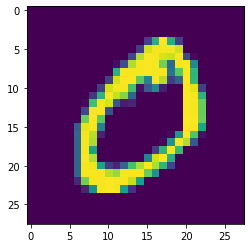

In [5]:
plt.imshow(qmnist['data'][1])

# Reusing Keras VAE code

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs) -> tf.Tensor:
        # inputs is the tensor of shape (batch_size, d0, d1,...)
        # In this case, the shape is -> (batch_size, 2)
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]  # batch_size
        dim = tf.shape(z_mean)[1]    # 2
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + epsilon * tf.exp(0.5 * z_log_var)           # mu + sqrt(var) * epsilon


if not use_vae_alt:

    ################ ENCODER ################
    latent_dim = 2

    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(encoder_inputs)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same", strides=(2,2))(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)

    # Pass this last layer's output to both mean layer and variance layer
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling layer takes the mean and variance as tensor inputs
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    ################ DECODER ################
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)  # arbitrary units
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

    # Last layer reduces color channels to 1
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

## Define the VAE as a Model with a custom train_step

In [7]:
kl_term = 1e0

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get the outputs of the first part of the model, the encoder
            # Outputs are:
            #              - mu
            #              - log variance
            #              - z = latent sampled vector
            z_mean, z_log_var, z = self.encoder(data)
            
            # Decode z
            reconstruction = self.decoder(z)
            
            # Recon loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # KL loss between a normal distribution N(mu, sigma) and N(0,1) --> D( N(mu,sigma) || N(0,1))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_term * kl_loss
        
        # Get computed grqdients
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Pass the gradients and the trainable_weights to the optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  # self.trainable_weight is also returned by self.trainable_variables(https://github.com/tensorflow/tensorflow/blob/285c6a0fa1d5a3d2a96507ac9f707ce5c0e3ac1f/tensorflow/python/layers/base.py#L183)
        
        # Update state of loss functions
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# Second way: using add_loss

In [8]:
import keras.backend as K
from keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Lambda
from keras import Model

def encoder_alt(input_shape=(28, 28, 1), latent_dim=2) -> tf.keras.Model:
    input_img_tensor = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, 3, padding='same', activation='relu')(input_img_tensor)
    x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    last_convolution_shape = list(x.shape)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    
    # Statistics
    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_sigma = Dense(latent_dim, name='latent_sigma')(x)
    
    # Reparametrization trick
    def sample_z(args: list) -> tf.Tensor:
        z_mu, z_sigma = args
        mu_shape = K.shape(z_mu)
        eps = K.random_normal(shape=(mu_shape[0], mu_shape[1]))
        return z_mu + K.exp(z_sigma / 2) * eps
    
    sample = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])  # z_mu, z_sigma = args
    
    encoder = Model(input_img_tensor, [z_mu, z_sigma, sample], name='encoder')
    return encoder, input_img_tensor, sample, z_mu, z_sigma, last_convolution_shape

num_channels = 1

def decoder_alt(conv_shape=(14,14,64), latent_dim=2):
    decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
    x = Dense(conv_shape[0]*conv_shape[1]*conv_shape[2], activation='relu')(decoder_input)
    x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]))(x)
    x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
    x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)
    decoder = Model(decoder_input, x, name='decoder')
    return decoder

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x
    
def get_vae_alt_model(input_shape=(28,28,1), latent_dim=2):
    # First get the encoder Model and all the tensors (and the conv_shape) needed for decoder and assembling both models
    encoder, input_img_tensor, sample, z_mu, z_sigma, conv_shape = encoder_alt(input_shape=input_shape, latent_dim=latent_dim)
    
    # Get the decoder Model
    decoder = decoder_alt(conv_shape=(14,14,64), latent_dim=latent_dim)
    
    # Apply the decoder to the sampled tensor from the estimated distribution of statistics z_mu and z_sigma
    z_decoded = decoder(sample)
    
    # The Custom layer applies the loss function that drives the learning of the VAE
    y = CustomLayer()([input_img_tensor, z_decoded, z_mu, z_sigma])  # loss = f(y_true, y_pred)
    
    # Return final model
    return Model(input_img_tensor, y, name='vae'), encoder, decoder

In [9]:
if use_vae_alt:
    vae_alt, encoder, decoder = get_vae_alt_model()
    vae_alt.summary()

2022-05-29 03:39:32.972358: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
________________________________________________________________________________________________

In [10]:
mnist_digits = qmnist['data']

# Normalize
mnist_digits = mnist_digits.astype('float32')
mnist_digits = mnist_digits / 255

shape = mnist_digits.shape

mnist_digits = mnist_digits.reshape(shape[0], shape[1], shape[2], 1)  # (120000, 28,28,1)--> has 1 color channel

vae_alt.compile(optimizer=keras.optimizers.Adam())
history = vae_alt.fit(mnist_digits, epochs=30, batch_size=128)

2022-05-29 03:39:34.070543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
938/938 [==============================] - 190s 201ms/step - loss: 0.2374
Epoch 2/30
938/938 [==============================] - 189s 201ms/step - loss: 0.1967
Epoch 3/30
938/938 [==============================] - 191s 203ms/step - loss: 0.1899
Epoch 4/30
938/938 [==============================] - 192s 204ms/step - loss: 0.1866
Epoch 5/30
938/938 [==============================] - 193s 206ms/step - loss: 0.1847
Epoch 6/30
938/938 [==============================] - 194s 207ms/step - loss: 0.1833
Epoch 7/30
938/938 [==============================] - 195s 207ms/step - loss: 0.1821
Epoch 8/30
938/938 [==============================] - 192s 205ms/step - loss: 0.1811
Epoch 9/30
938/938 [==============================] - 192s 205ms/step - loss: 0.1804
Epoch 10/30
938/938 [==============================] - 194s 206ms/step - loss: 0.1797
Epoch 11/30
938/938 [==============================] - 191s 204ms/step - loss: 0.1791
Epoch 12/30
938/938 [==============================] - 195s 207

In [11]:
def plot_latent_space_alt(encoder, decoder, n=30, figsize=15): 
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters_alt(encoder, data, labels, opacity=1.0):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, alpha=opacity)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Save model

In [12]:
vae_alt.save_weights('mnist_vae_alt_yt_2.h5')

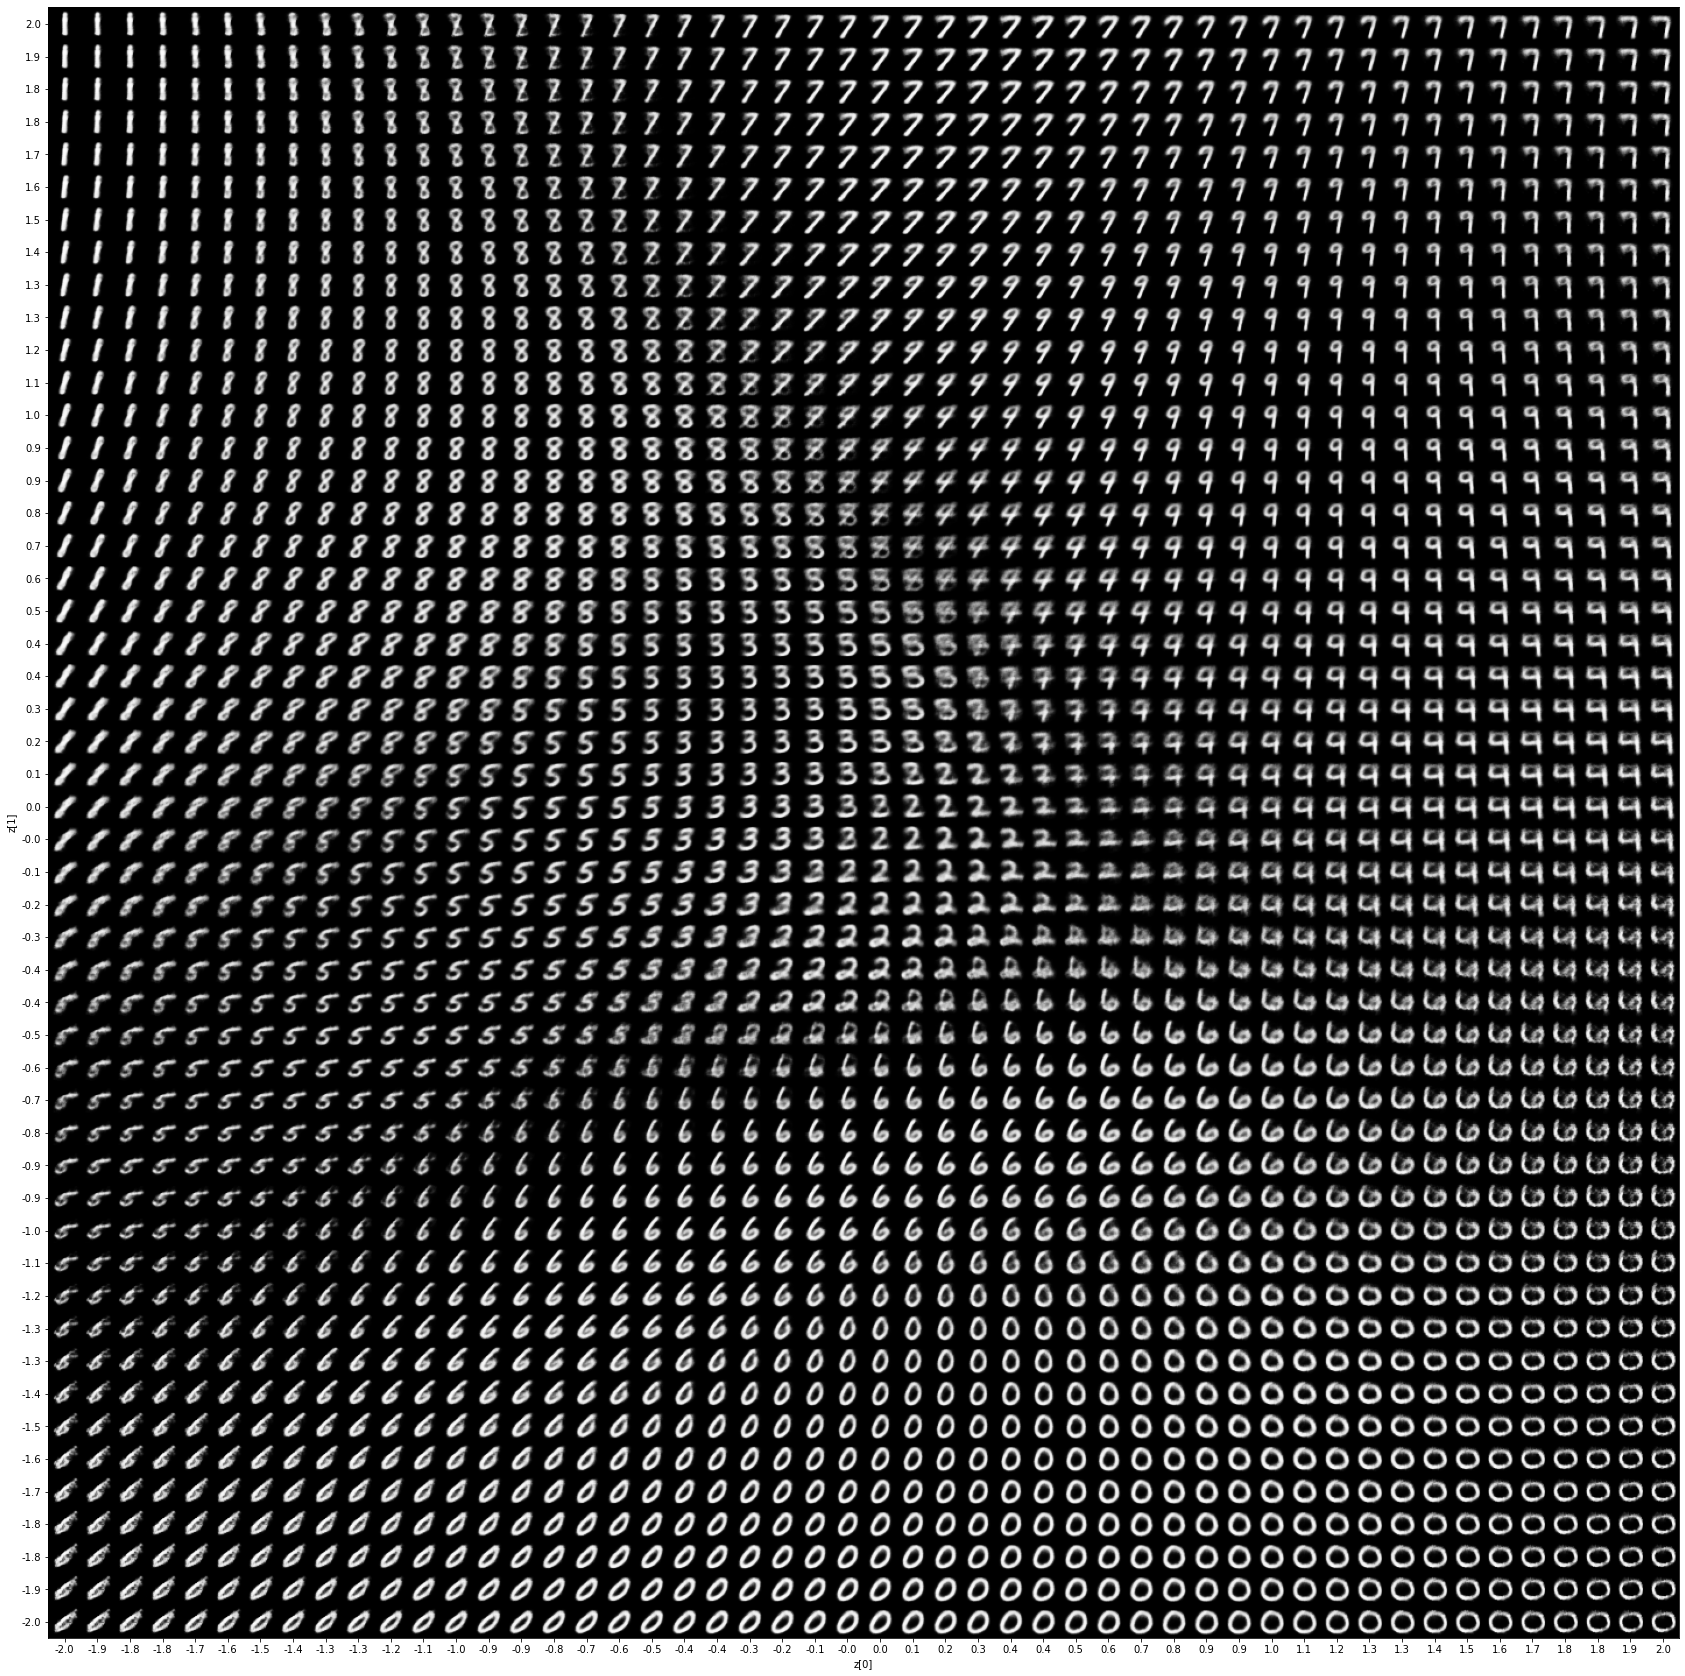

In [13]:
plot_latent_space_alt(encoder, decoder, n=50, figsize=30)

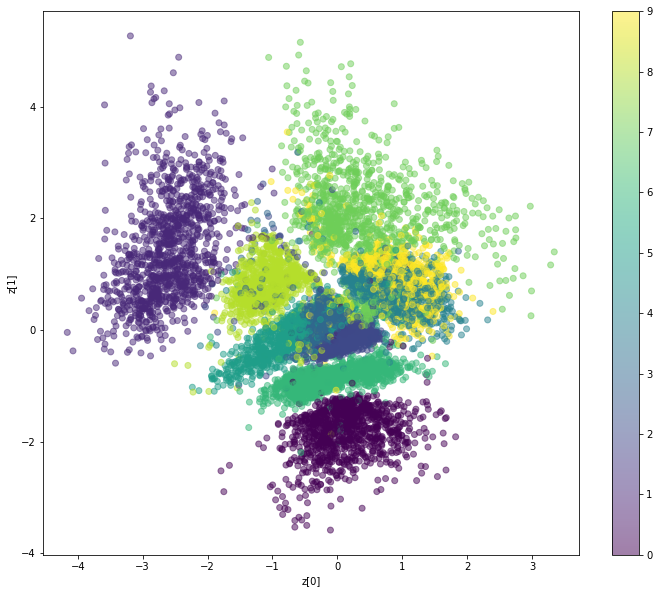

In [14]:
plot_label_clusters_alt(encoder, mnist_digits[0:10000], qmnist['labels'][0:10000], opacity=0.5)